# Tarea 3

Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado. Algo como lo siguiente:

Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase.

Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos:
https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true


In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [62]:
# El horizonte de predicción que se desea con el modelo
HORIZONTE = 20

In [69]:
class LinearForecast:
    def __init__(self, data):
        self.data = data

    def adf_test(self):
        print("Results of Dickey-Fuller Test:")
        dftest = adfuller(self.data, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)

        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")

        # Graficar ACF y PACF
    def plot_acf_pacf(self, kwargs=dict()):
        f = plt.figure(figsize=(8,5))

        ax1 = f.add_subplot(121)

        plot_acf(self.data, zero=False, ax=ax1, **kwargs)

        ax2 = f.add_subplot(122)
        plot_pacf(self.data, zero=False, ax=ax2, method='ols', **kwargs)

        plt.show()

    def descomposicion(self):
        data1 = self.data.copy()
        periods_seasonality = (6, 12)

        stl_kwargs = {"seasonal_deg": 0}
        model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
        res2 = model.fit()

        # Gráfica de descomposición
        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')

        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')

        res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

        res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

        res2.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')

        fig.tight_layout()

        return res2

    def split_dataset(self):
        """
        Función que se encarga de dividir la data ingresada en datos de entrenamiento y prueba.
        :param data: Data con la información de la serie de tiempo a analizar.
        """

        train_data, test_data = train_test_split(self.data, test_size=0.2, random_state=0, shuffle=False)

        return train_data, test_data

    def evaluate_forecasts(self, actual, predicted):
        """
        Función que se encargará de calcular las métricas de error. (MSE, RMSE, MAD, MAPE)
        :param actual: Valor actual de la serie de tiempo que se desea predecir.
        :param predicted: Valor predecido por el modelo ajustado.
        """
        mse = mean_squared_error(actual, predicted)
        rmse = mean_squared_error(actual, predicted, squared=True)
        mad = mean_absolute_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)

        return mse, rmse, mad, mape


    def evaluate_model(model_func, train, test):
        """
        Función que se encargará de evaluar el modelo y calcular las métricas de error.
        :param model_func: Función del modelo que se encarga de entrenar y predecir un horizonte
                           de tiempo HORIZONTE.
        :param train: Datos de entrenamiento.
        :param test: Datos de prueba.
        """

### Serie de tiempo
Leyendo los datos con los que se trabajarán.

In [3]:
data = pd.read_excel('https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true')
data.head(20)

,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.6320
1,7,1990-01-01,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.4090
2,8,1990-01-01,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.1540
3,9,1990-01-01,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.2730
4,10,1990-01-01,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.2300
5,11,1990-01-01,1990,Jan,Mon,11,1081,1034,95,14.6625,8.5,991.1800
6,12,1990-01-01,1990,Jan,Mon,12,1093,1038,95,14.8500,8.2,992.9360
7,13,1990-01-01,1990,Jan,Mon,13,1040,1039,84,14.7094,9.1,992.3160
8,14,1990-01-01,1990,Jan,Mon,14,929,1028,72,14.7531,8.9,991.2440
9,15,1990-01-01,1990,Jan,Mon,15,779,1008,67,14.5688,9.5,982.6840


In [4]:
data.shape

(97000, 12)

In [5]:
data["date"].describe()

/var/folders/vy/11j1fpvs73d2q6m6tfbtxl4c0000gn/T/ipykernel_5014/1251105001.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data["date"].describe()


count                   97000
unique                   9125
top       2014-12-31 00:00:00
freq                       13
first     1990-01-01 00:00:00
last      2014-12-31 00:00:00
Name: date, dtype: object

In [6]:
data["date"].value_counts()

2014-12-31    13
1995-02-10    13
2005-06-02    13
2005-05-02    13
2005-03-02    13
              ..
1996-04-11     1
2010-04-11     1
2013-04-11     1
2005-04-11     1
2001-04-11     1
Name: date, Length: 9125, dtype: int64

Cada fecha tiene diferentes frecuencias, por eso es preferible agregar los datos usando el promedio mensual.

In [7]:
timeseries = data[['date', 'Energy (kWh)']]
timeseries.columns = ['date', 'y']
#timeseries.drop_duplicates("date", inplace=True)
#timeseries = timeseries.set_index('date').asfreq("MS")

# Hacer un re muestreo de los datos para que queden de forma mensual (promediarlos)
timeseries = timeseries.set_index('date').resample('M').mean()
timeseries.head()

,y
date,
1990-01-31,451.887005
1990-02-28,423.897505
1990-03-31,430.298776
1990-04-30,296.197605
1990-05-31,288.352006


In [8]:
timeseries.shape

(300, 1)

<AxesSubplot:xlabel='date'>

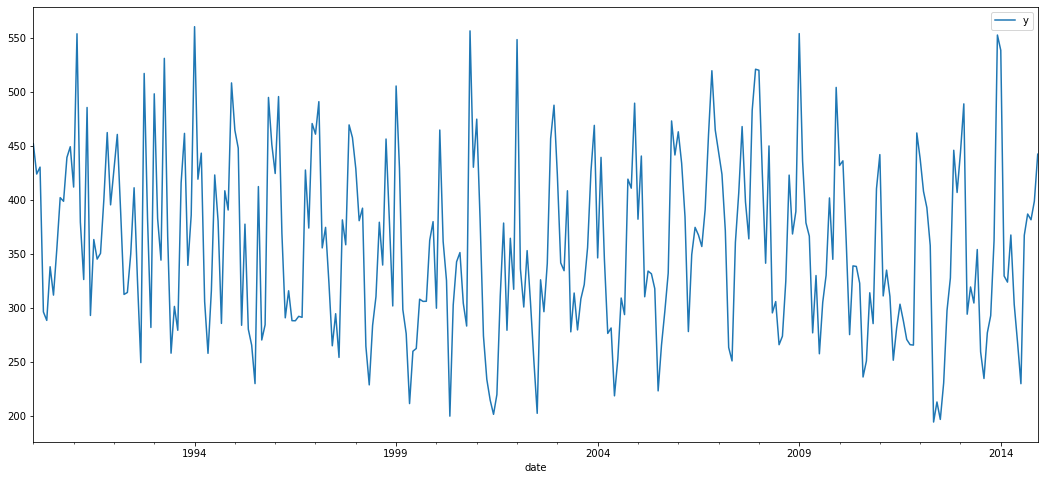

In [9]:
# Serie de tiempo del consumo de energía de 25 años (1990 a 2014)
timeseries.plot(figsize=(18,8))

In [10]:
timeseries

,y
date,
1990-01-31,451.887005
1990-02-28,423.897505
1990-03-31,430.298776
1990-04-30,296.197605
1990-05-31,288.352006
...,...
2014-08-31,367.172808
2014-09-30,386.856567
2014-10-31,381.547674


- Variable de respuesta a utilizar: Energy
- La variable de fecha viene el primer día del mes por año.

In [11]:
timeseries.dtypes

y    float64
dtype: object

## ADF Test

In [12]:
LinearForecast(timeseries).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


Como el p-value es mayor a 0.05 podemos confirmar que la serie no es estacionaria.

In [13]:
LinearForecast(timeseries.diff().dropna()).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -1.185352e+01
p-value                        7.115964e-22
#Lags Used                     1.200000e+01
Number of Observations Used    2.860000e+02
Critical Value (1%)           -3.453423e+00
Critical Value (5%)           -2.871699e+00
Critical Value (10%)          -2.572183e+00
dtype: float64
Stationary


Ahora como el p-value es menor a 0.05, la serie diferenciada sí es estacionaria.

## Descomposición

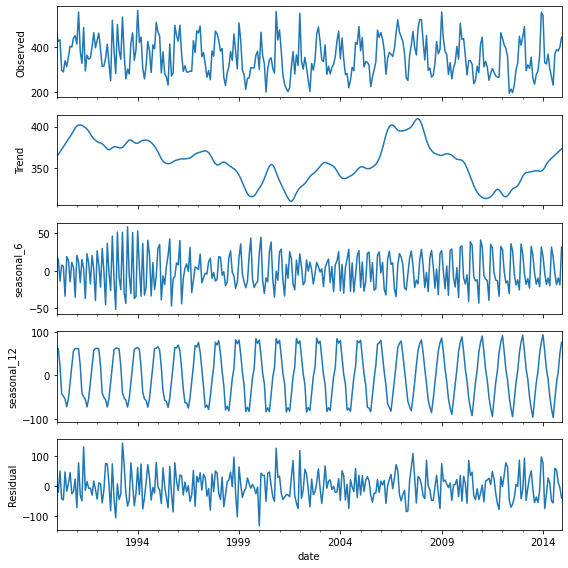

In [14]:
res = LinearForecast(timeseries).descomposicion()
res

<AxesSubplot:xlabel='date'>

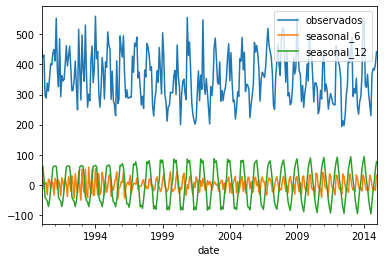

In [15]:
ax = res.observed.to_frame('observados').plot()
res.seasonal.plot(ax=ax)

## Parámetros de estacionalidad (P, D, Q, S)

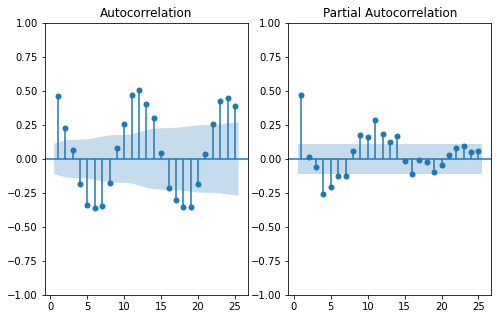

In [16]:
# Autocorrelación
LinearForecast(timeseries).plot_acf_pacf()

La estacionalidad tiene un patrón cada 6 y 12 meses.

In [25]:
seasonality_6 = res.seasonal['seasonal_6']
LinearForecast(seasonality_6).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -9.451841e+00
p-value                        4.594080e-16
#Lags Used                     1.600000e+01
Number of Observations Used    2.830000e+02
Critical Value (1%)           -3.453670e+00
Critical Value (5%)           -2.871808e+00
Critical Value (10%)          -2.572241e+00
dtype: float64
Stationary


In [26]:
seasonality_12 = res.seasonal['seasonal_12']
LinearForecast(seasonality_12).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                 -29.256349
p-value                          0.000000
#Lags Used                      16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64
Stationary


Encontrando P, D, Q, S

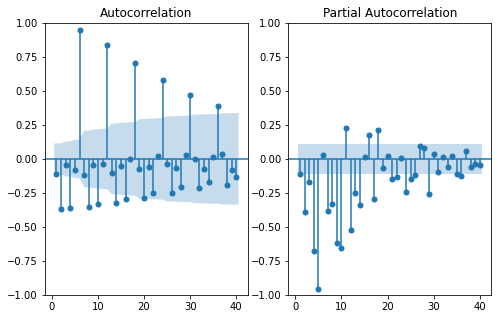

In [33]:
LinearForecast(seasonality_6).plot_acf_pacf({'lags': 40})

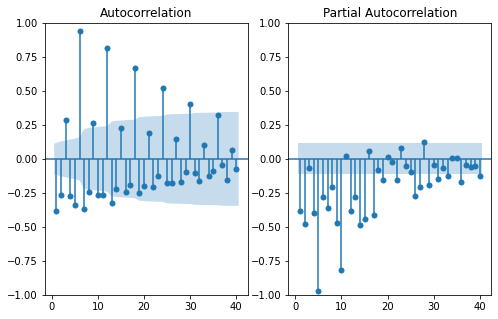

In [28]:
# Graficar ACF y PACF - > Analizar el caso cuando se diferencia la serie estacional seleccionada
LinearForecast(seasonality_6.diff().dropna()).plot_acf_pacf({'lags': 40})

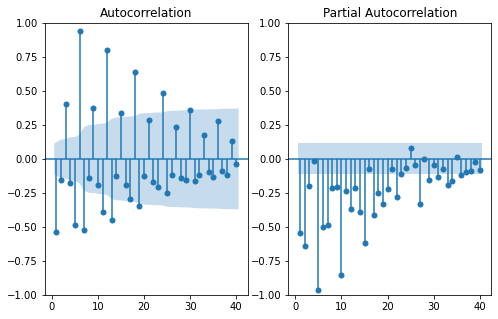

In [35]:
LinearForecast(seasonality_6.diff().diff().dropna()).plot_acf_pacf({'lags': 40})

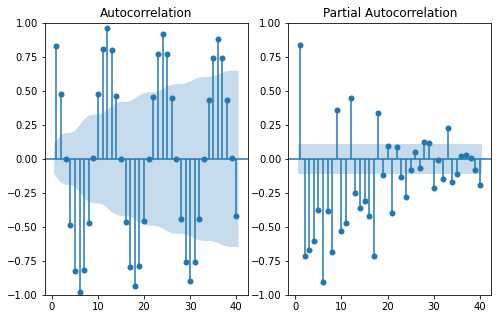

In [34]:
LinearForecast(seasonality_12).plot_acf_pacf({'lags': 40})

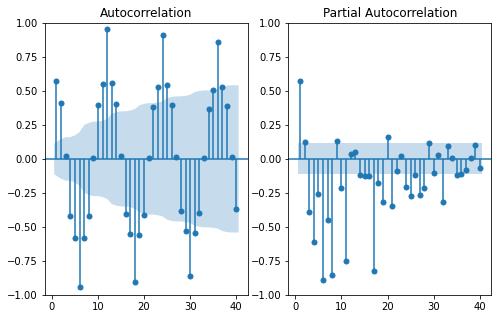

In [29]:
LinearForecast(seasonality_12.diff().dropna()).plot_acf_pacf({'lags': 40})

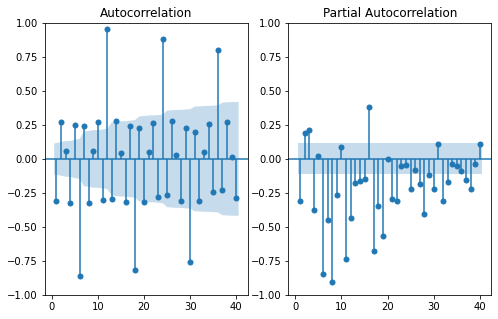

In [36]:
LinearForecast(seasonality_12.diff().diff().dropna()).plot_acf_pacf({'lags': 40})

Estacionalidad: 6
Q: 0-2
P: 0-5

## Parámetros no estacionales

In [39]:
LinearForecast(res.observed).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


<AxesSubplot:xlabel='date'>

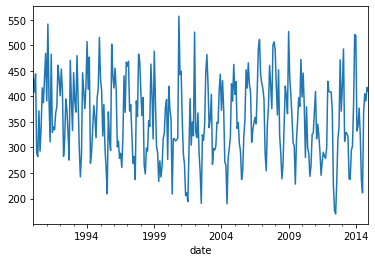

In [40]:
# Calcular la componente no estacional de la serie temporal
non_seasonal = res.observed - res.seasonal['seasonal_6']
non_seasonal.plot()

In [44]:
# Calcular si la serie no estacional es estacionaria o no
LinearForecast(non_seasonal).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                  -2.287739
p-value                          0.175953
#Lags Used                      15.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64
Non-stationary


In [45]:
# Calcular si la serie no estacional es estacionaria o no
LinearForecast(non_seasonal.diff().dropna()).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                  -5.001408
p-value                          0.000022
#Lags Used                      16.000000
Number of Observations Used    282.000000
Critical Value (1%)             -3.453754
Critical Value (5%)             -2.871844
Critical Value (10%)            -2.572261
dtype: float64
Stationary


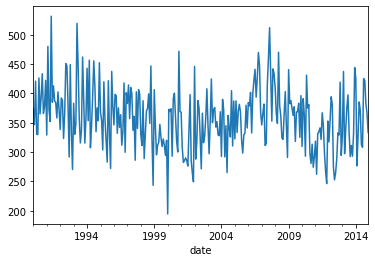

In [42]:
non_seasonal2 = res.observed - res.seasonal['seasonal_6'] - res.seasonal['seasonal_12']
ax = non_seasonal2.plot()
plt.show()

In [43]:
# Calcular si la serie no estacional es estacionaria o no
LinearForecast(non_seasonal2).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                  -2.652388
p-value                          0.082646
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


In [46]:
# Calcular si la serie no estacional es estacionaria o no
LinearForecast(non_seasonal2.diff().dropna()).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -7.982167e+00
p-value                        2.605812e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64
Stationary


La serie se volvió estacionaria después de diferenciarla una vez, por eso se usará d=1. Se calculará p y q con la serie de tiempo diferenciada.

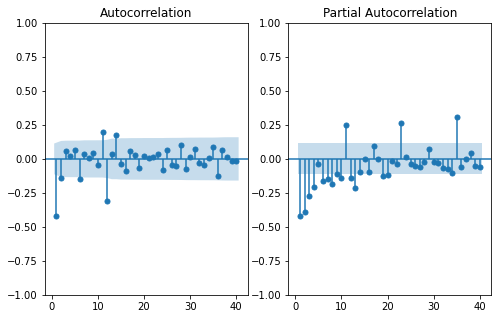

In [53]:
# Graficar ACF y PACF para obtener valores de p y q (analizar el efecto de diferenciar diff())
LinearForecast((non_seasonal2.diff().dropna())).plot_acf_pacf({'lags': 40})

Se usarán los siguientes parámetros:
p = 0-4
q = 0-2

In [107]:
import itertools

# Posibles valores en lo que pueden variar los parámetros de un SARIMAX
# Parte no estacional
p = [0, 1, 2]
d = [1]
q = [0, 1, 2]
# Parte estacional
P = [0, 1, 2]
D = [0]
Q = [0, 1, 2]
# Tipo de tendencia
t = ['n', 'c', 't', 'ct']

# Explorar función itertools.product

# Diferentes conmbinaciones

# sarimax_params
param_no_estacionales = list(itertools.product(p, d, q))
param_estacionales = [(x[0], x[1], x[2], 6 ) for x in list(itertools.product(P, D, Q))]
sarimax_params = list(itertools.product(param_no_estacionales, param_estacionales, t))
sarimax_params

[((0, 1, 0), (0, 0, 0, 6), 'n'),
 ((0, 1, 0), (0, 0, 0, 6), 'c'),
 ((0, 1, 0), (0, 0, 0, 6), 't'),
 ((0, 1, 0), (0, 0, 0, 6), 'ct'),
 ((0, 1, 0), (0, 0, 1, 6), 'n'),
 ((0, 1, 0), (0, 0, 1, 6), 'c'),
 ((0, 1, 0), (0, 0, 1, 6), 't'),
 ((0, 1, 0), (0, 0, 1, 6), 'ct'),
 ((0, 1, 0), (0, 0, 2, 6), 'n'),
 ((0, 1, 0), (0, 0, 2, 6), 'c'),
 ((0, 1, 0), (0, 0, 2, 6), 't'),
 ((0, 1, 0), (0, 0, 2, 6), 'ct'),
 ((0, 1, 0), (1, 0, 0, 6), 'n'),
 ((0, 1, 0), (1, 0, 0, 6), 'c'),
 ((0, 1, 0), (1, 0, 0, 6), 't'),
 ((0, 1, 0), (1, 0, 0, 6), 'ct'),
 ((0, 1, 0), (1, 0, 1, 6), 'n'),
 ((0, 1, 0), (1, 0, 1, 6), 'c'),
 ((0, 1, 0), (1, 0, 1, 6), 't'),
 ((0, 1, 0), (1, 0, 1, 6), 'ct'),
 ((0, 1, 0), (1, 0, 2, 6), 'n'),
 ((0, 1, 0), (1, 0, 2, 6), 'c'),
 ((0, 1, 0), (1, 0, 2, 6), 't'),
 ((0, 1, 0), (1, 0, 2, 6), 'ct'),
 ((0, 1, 0), (2, 0, 0, 6), 'n'),
 ((0, 1, 0), (2, 0, 0, 6), 'c'),
 ((0, 1, 0), (2, 0, 0, 6), 't'),
 ((0, 1, 0), (2, 0, 0, 6), 'ct'),
 ((0, 1, 0), (2, 0, 1, 6), 'n'),
 ((0, 1, 0), (2, 0, 1, 6), 'c'),
 ((

In [108]:
len(sarimax_params)

324

<AxesSubplot:>

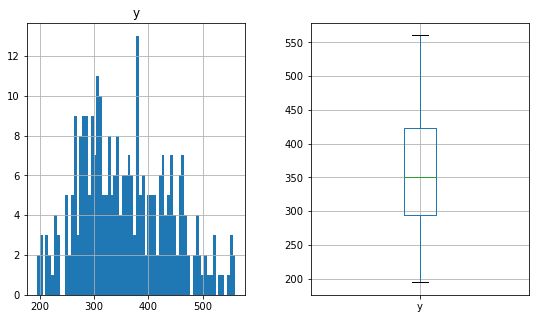

In [109]:
# Obtener histograma con la transformación logarítmica y sqrt
fig, ax = plt.subplots(1,2, figsize=(9, 5))
timeseries.hist(bins=70, ax=ax[0])
timeseries.boxplot(ax=ax[1])

Los datos están ligeramente sesgados a la derecha, por eso se usará un método de transformación de datos para que se parezca más a una distribución normal.

<AxesSubplot:>

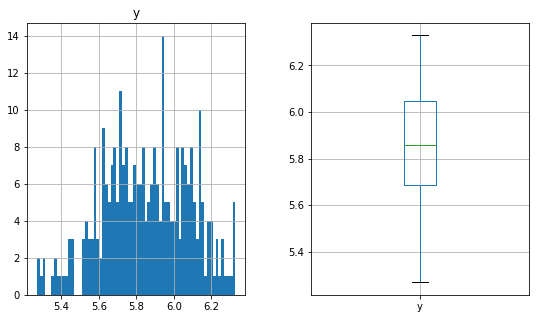

In [110]:
# Obtener histograma con la transformación logarítmica y sqrt
fig, ax = plt.subplots(1,2, figsize=(9, 5))
np.log(timeseries).hist(bins=70, ax=ax[0])
np.log(timeseries).boxplot(ax=ax[1])

In [111]:
par_no_esta, par_esta, trend = (sarimax_params[0])
par_no_esta

(0, 1, 0)

In [112]:
train, test = LinearForecast(timeseries).split_dataset()
train

,y
date,
1990-01-31,451.887005
1990-02-28,423.897505
1990-03-31,430.298776
1990-04-30,296.197605
1990-05-31,288.352006
...,...
2009-08-31,305.111702
2009-09-30,330.127065
2009-10-31,401.772201


<AxesSubplot:>

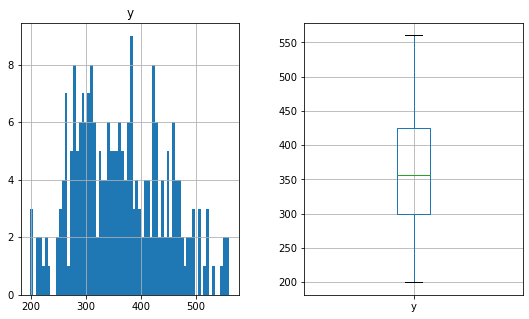

In [113]:
# Obtener histograma con la transformación logarítmica y sqrt
fig, ax = plt.subplots(1,2, figsize=(9, 5))
train.hist(bins=70, ax=ax[0])
train.boxplot(ax=ax[1])

In [114]:
# Se transoforma el train a logaritmo
train_log = np.log(train)
train_log

,y
date,
1990-01-31,6.113432
1990-02-28,6.049492
1990-03-31,6.064480
1990-04-30,5.691027
1990-05-31,5.664182
...,...
2009-08-31,5.720678
2009-09-30,5.799478
2009-10-31,5.995885


In [115]:
test

,y
date,
2010-01-31,431.777998
2010-02-28,436.116297
2010-03-31,360.582118
2010-04-30,275.169312
2010-05-31,338.813391
2010-06-30,338.329636
2010-07-31,322.758095
2010-08-31,235.937899
2010-09-30,250.744176


In [116]:
# encuentre el 'conjunto más adecuado' de parámetros no estacionales y estacionales
n = 5
resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'], index=np.arange(0, len(sarimax_params)))

i = 0
for par_no_esta, par_esta, trend in sarimax_params:
    mod = SARIMAX(
        endog=train_log,
        trend=trend,
        order=par_no_esta,
        seasonal_order=par_esta
    )
    results = mod.fit(disp=False)

    resultados.loc[i, 'params'] = str((par_no_esta, par_esta, trend))
    resultados.loc[i, 'AIC'] = results.aic
    resultados.loc[i, 'BIC'] = results.bic
    resultados.loc[i, 'LLF'] = results.llf
    i += 1

#     print(f'AIC={results.aic}', f'BIC={results.bic}', f'Log-likelihood={results.llf}', sep='\n')

/Users/rosaura/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rosaura/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rosaura/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rosaura/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rosaura/opt/anaconda3/lib/python3.9/s

In [117]:
resultados.sort_values(by=['AIC'], ascending=True)

,params,AIC,BIC,LLF
160,"((1, 1, 1), (1, 0, 1, 6), 'n')",-151.177866,-133.795548,80.588933
268,"((2, 1, 1), (1, 0, 1, 6), 'n')",-150.381654,-129.522873,81.190827
196,"((1, 1, 2), (1, 0, 1, 6), 'n')",-150.277989,-129.419208,81.138995
68,"((0, 1, 1), (2, 0, 2, 6), 'n')",-149.212993,-128.354212,80.606497
280,"((2, 1, 1), (2, 0, 1, 6), 'n')",-148.830883,-124.495638,81.415441
...,...,...,...,...
22,"((0, 1, 0), (1, 0, 2, 6), 't')",-4.808717,12.573601,7.404359
19,"((0, 1, 0), (1, 0, 1, 6), 'ct')",-3.248621,14.133697,6.624311
34,"((0, 1, 0), (2, 0, 2, 6), 't')",-2.955843,17.902939,7.477921
23,"((0, 1, 0), (1, 0, 2, 6), 'ct')",-2.861924,17.996857,7.430962


Mojor modelo: params: ((0, 1, 1), (1, 0, 1, 12), 'n')

In [119]:
model = SARIMAX(
        endog=train_log,
        trend=trend,
        order=(1,1,1),
        seasonal_order=(1,0,1,6)
    )
results1 = model.fit(disp=False)

In [123]:
len(test)

60

In [132]:
forecast = results1.predict()

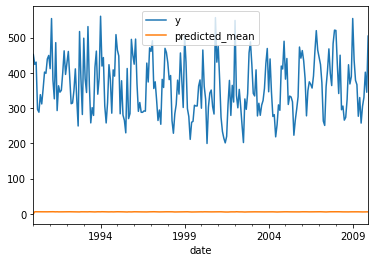

In [133]:
fig, ax = plt.subplots()
train.plot(ax=ax)
forecast.plot(ax=ax)
plt.legend()

## Conclusión
Tuve que utilizar menos parámetros en las combinaciones porque si colocaba todos los posibles parámetros que definí en el análisis arrojaba un error, era complicado para la computadora ejecutar tantos modelos. Al final obtuve que el mejor parámetro fue con los parámetros no estacioneles (1,1,1) y los parámetros estacionales (1,0,1,6) con una tendencia de "n".
Al final no logré tener una buena predicción.